In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from tqdm import tqdm

import numpy as np
import healpy as hp

import jax.numpy as jnp

sys.path.append("..")
import utils.create_mask as cm
from utils.binning import ebin_edges, ebin_engs, ebin_names

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
mpl.rc_file('../utils/matplotlibrc')

In [2]:
def plot_gc(z, mask=None, **kwargs):
    if mask is not None:
        nside = hp.npix2nside(len(mask))
        z_plot = np.zeros(hp.nside2npix(nside))
        z_plot[~mask] = z
    else:
        z_plot = z
    default_kwargs = dict(latra=[-25, 25], lonra=[-25, 25], hold=True, title='')
    default_kwargs.update(kwargs)

    hp.cartview(z_plot, **default_kwargs)

def plot_ebins(zebin, mask=None, suptitle=None, imcbar=False, **kwargs):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    for ie in range(10, 20):
        ax = axs.flat[ie-10]
        plt.sca(ax)
        plot_gc(zebin[ie], mask=mask, title=ebin_names[ie], **kwargs)
    if suptitle is not None:
        fig.suptitle(suptitle)

    if imcbar:
        #fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cmap = 'viridis' if 'cmap' not in kwargs else kwargs['cmap']
        norm = Normalize(vmin=kwargs['min'], vmax=kwargs['max'])
        cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')

## 1. Get physical values

In [3]:
data_dir = "../data/fermi_data_573w/ebin_128"

### 1.1 data, exposure, mask

In [4]:
mask_plane = cm.make_mask_total(band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=25)
#plot_gc(1, mask=mask_plane, cmap='binary_r')

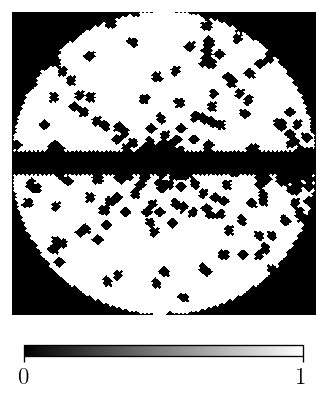

In [5]:
mask_ps = np.load("../data/mask_3fgl_0p8deg.npy")
mask_roi = np.logical_or(mask_ps, mask_plane)
plot_gc(1, mask=mask_roi, cmap='binary_r')

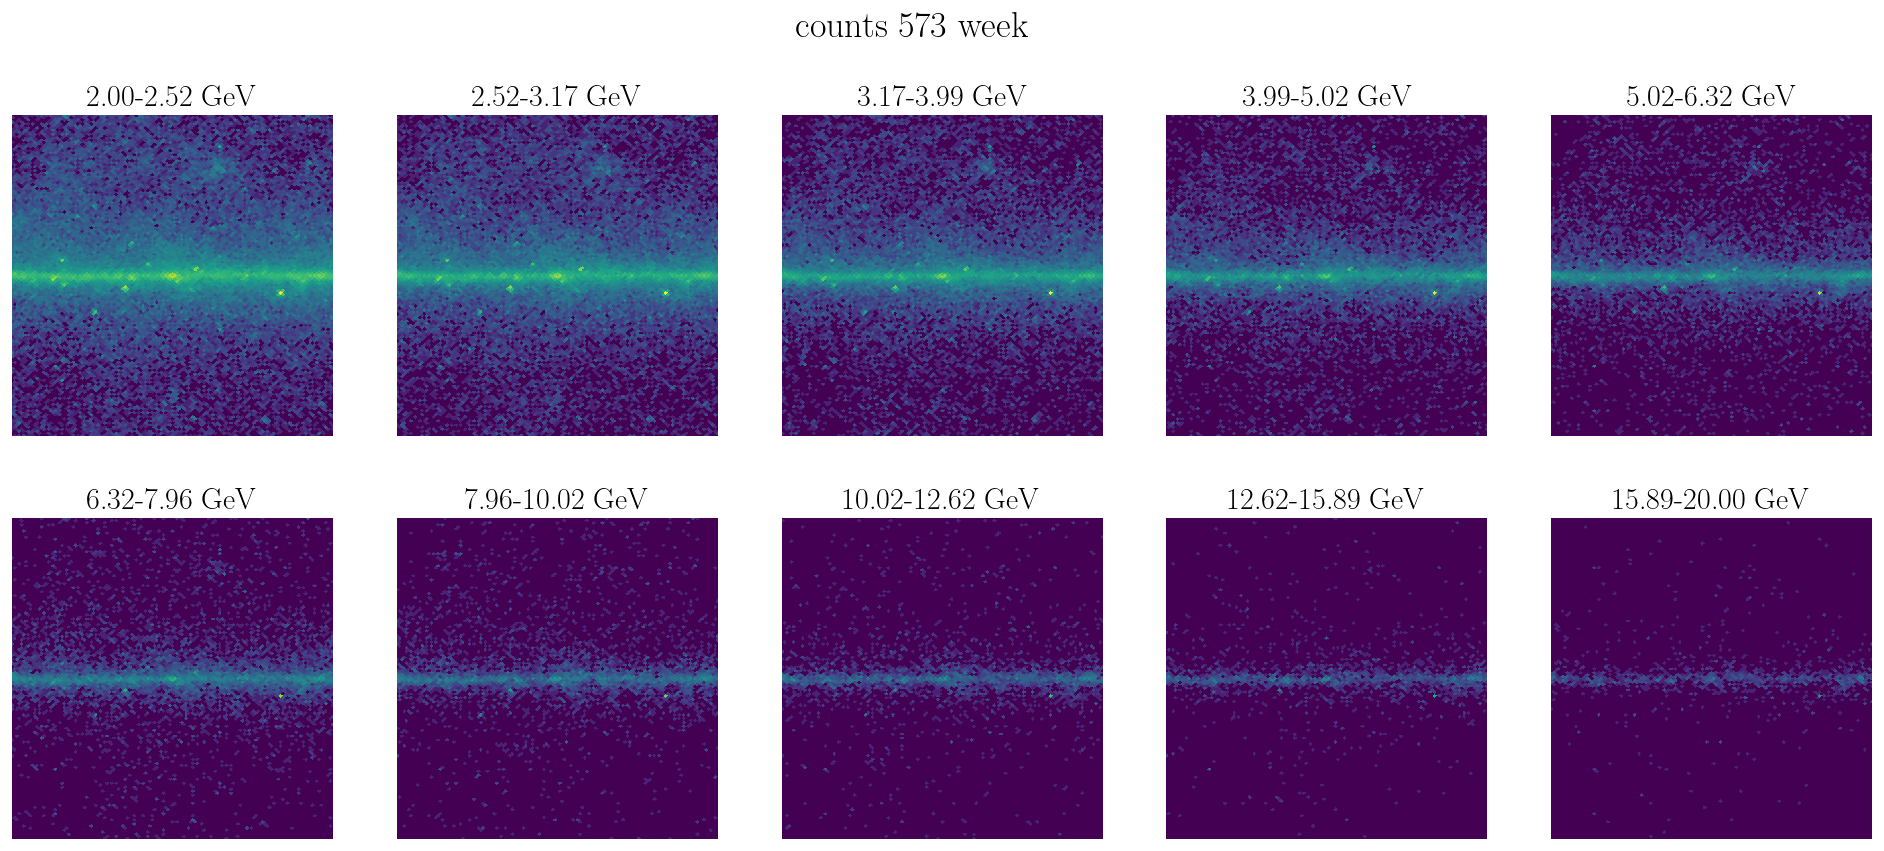

In [6]:
counts = np.load(data_dir + "/counts-fwhm000-0512-bestpsf-nopsc.npy")
plot_ebins(np.clip(counts, 0.5, None), suptitle='counts 573 week', norm='log', max=1000, min=1, cbar=False)

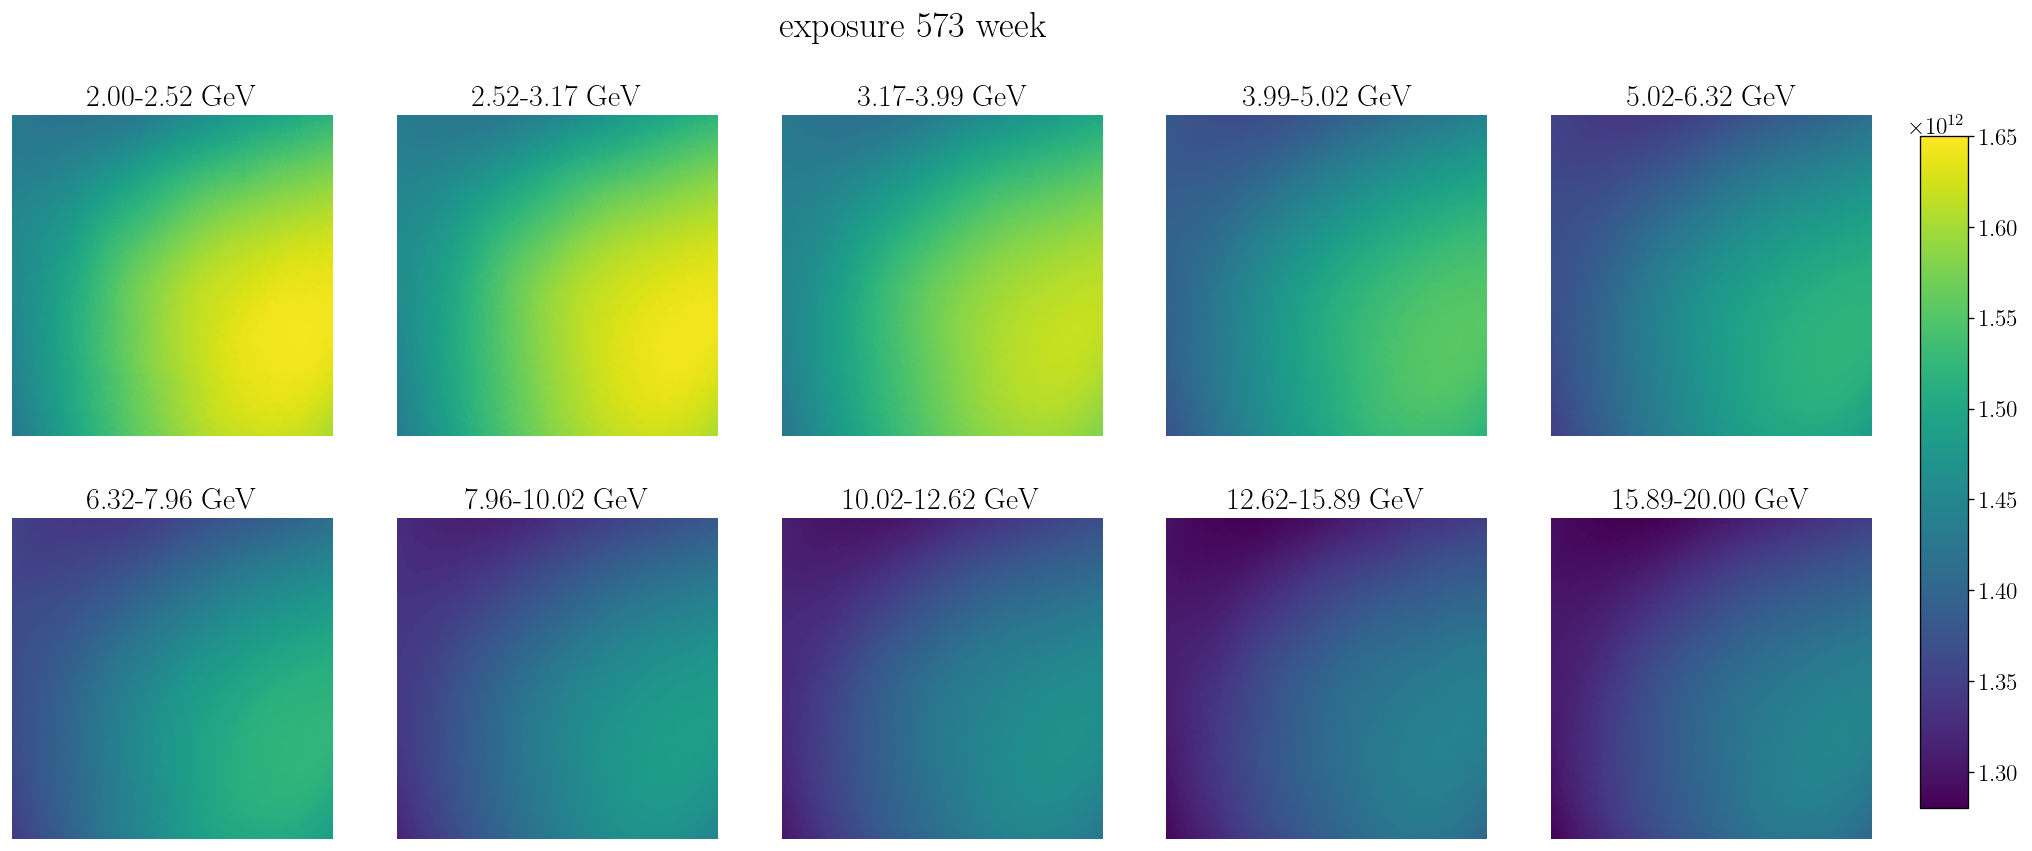

In [7]:
exposure = np.load(data_dir + "/exposure-fwhm000-0512-bestpsf-nopsc.npy")
plot_ebins(exposure, suptitle='exposure 573 week', imcbar=True, min=1.28e12, max=1.65e12, cbar=False)

### 1.2 pib ics bub 

/tmp/ipykernel_1417708/3526344312.py:2: RuntimeWarning: divide by zero encountered in log10
  plot_ebins(np.log10(modeloics), suptitle=r'$\log_{10}$(model O ICS)', imcbar=True, min=-0.5, max=0.75, cbar=False)


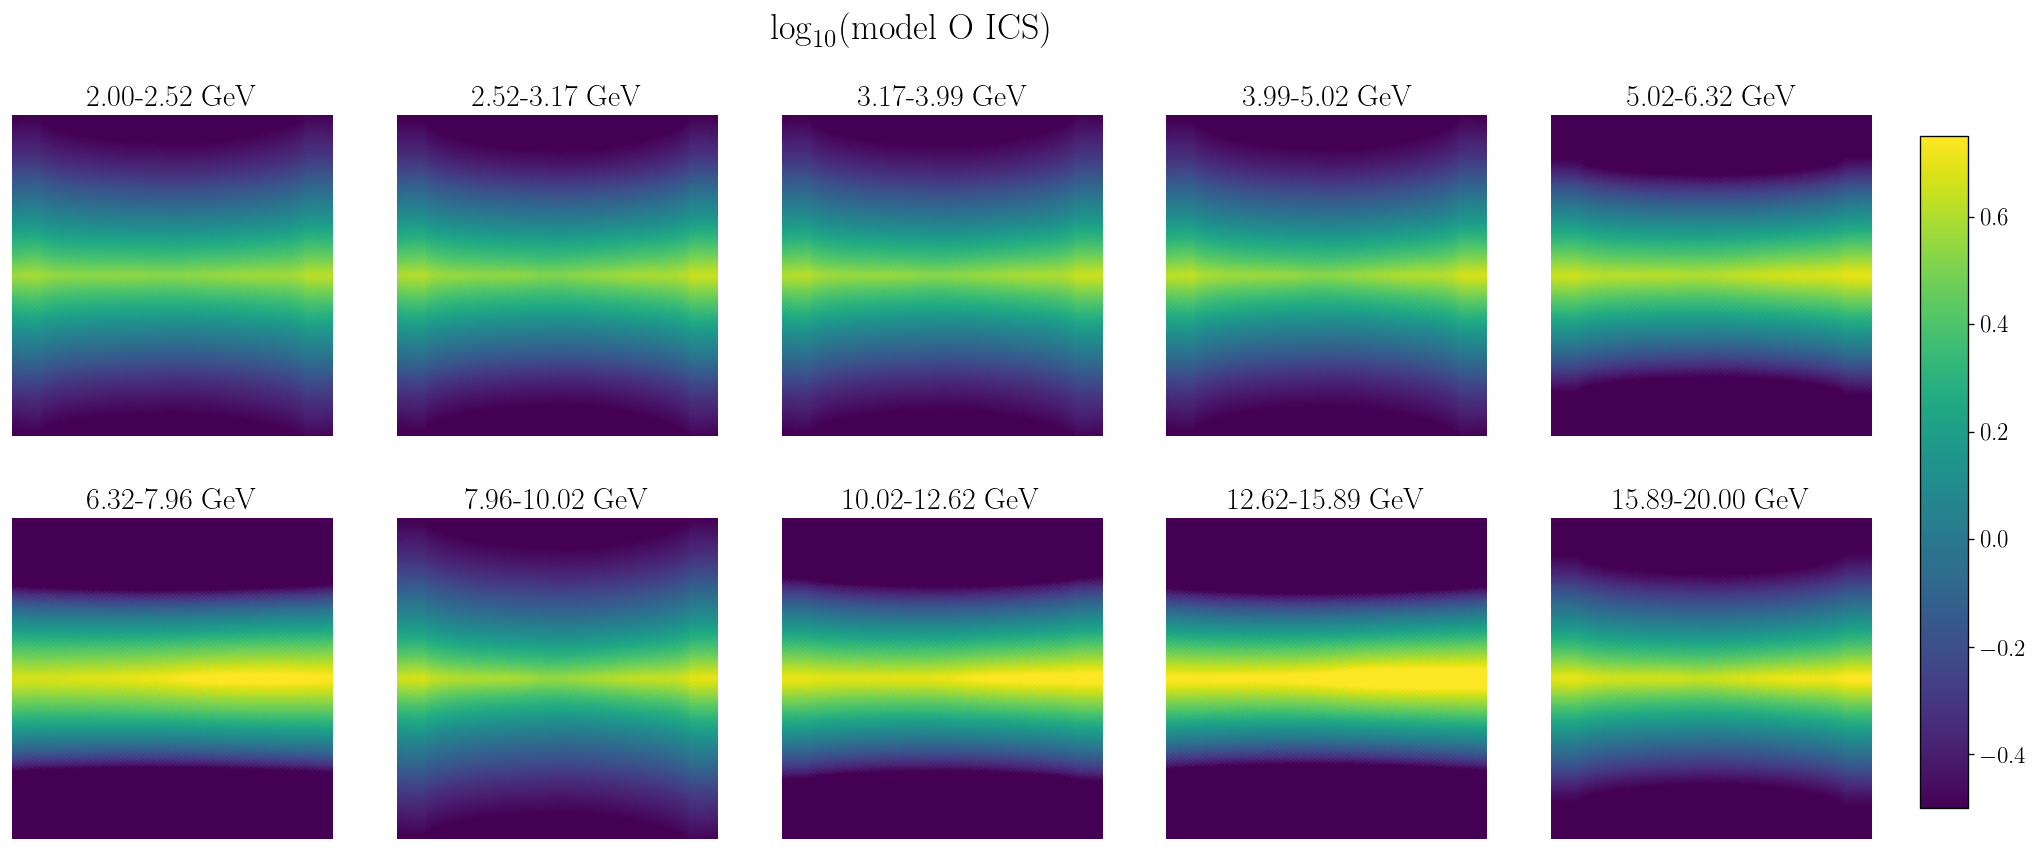

In [8]:
modeloics = np.load(data_dir + "/modeloics-ultracleanveto-bestpsf.npy")
plot_ebins(np.log10(modeloics), suptitle=r'$\log_{10}$(model O ICS)', imcbar=True, min=-0.5, max=0.75, cbar=False)

/tmp/ipykernel_1417708/1889118540.py:2: RuntimeWarning: divide by zero encountered in log10
  plot_ebins(np.log10(modelopib), suptitle=r'$\log_{10}$(model O Pi+Brem.)', imcbar=True, min=-0.5, max=2.5, cbar=False)


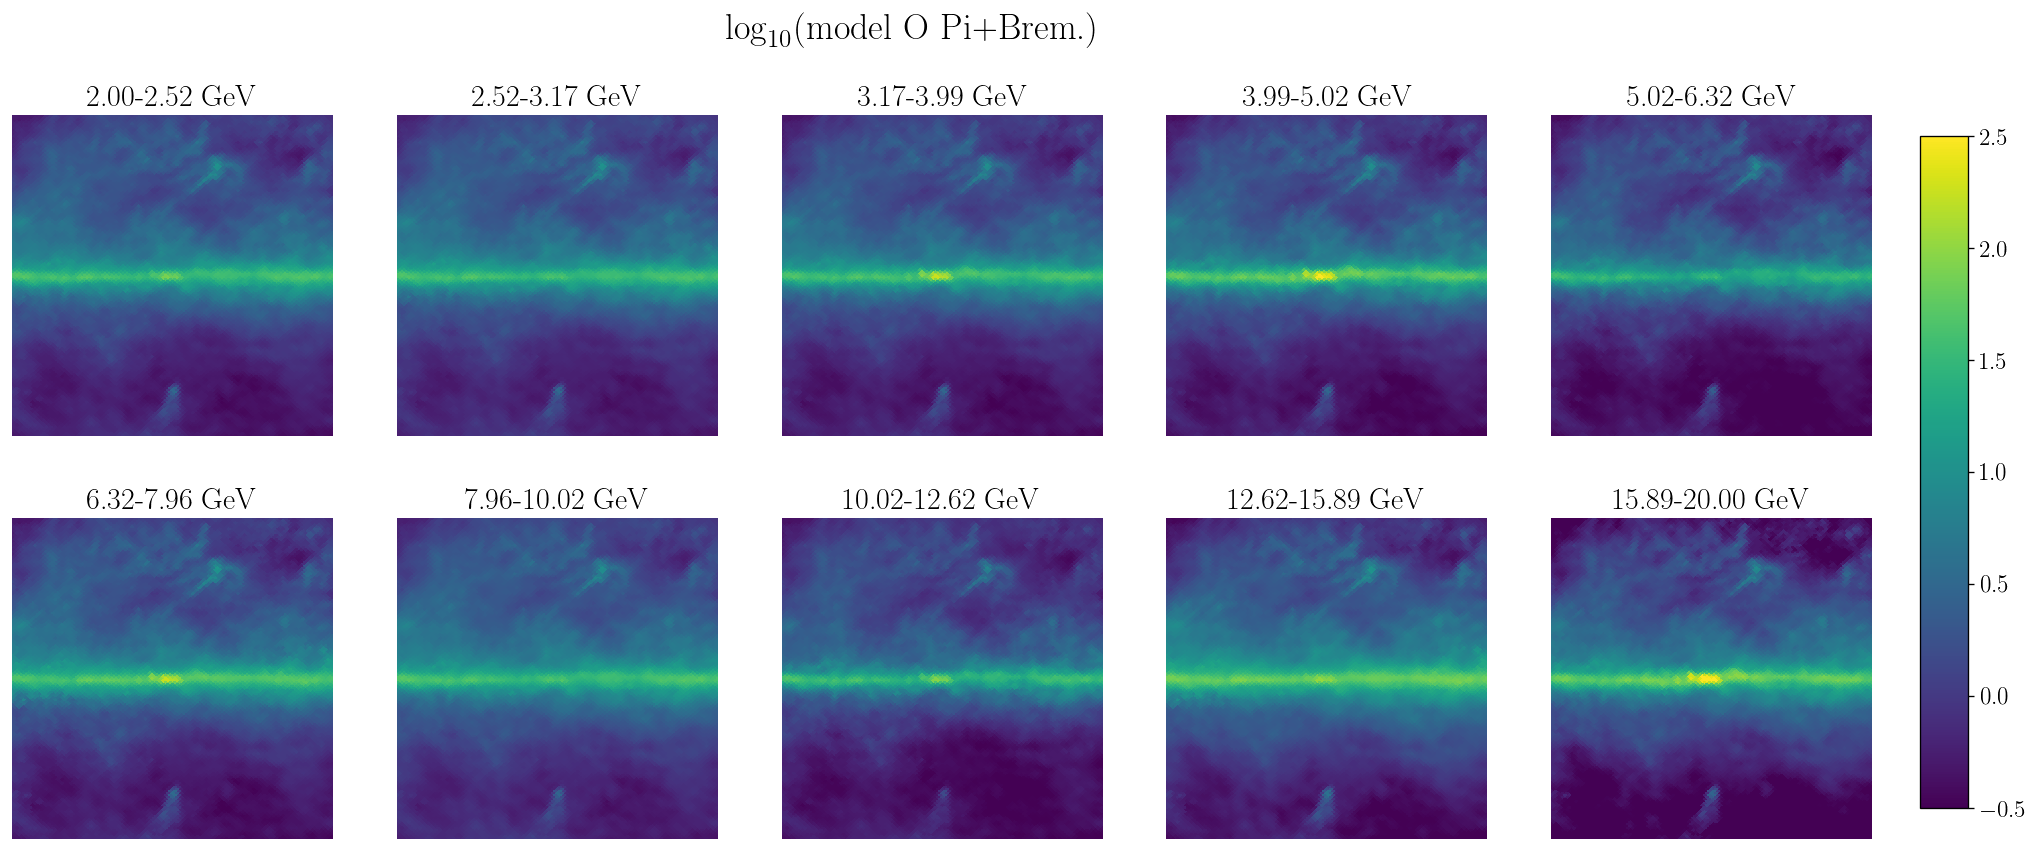

In [9]:
modelopib = np.load(data_dir + "/modelopibrem-ultracleanveto-bestpsf.npy")
plot_ebins(np.log10(modelopib), suptitle=r'$\log_{10}$(model O Pi+Brem.)', imcbar=True, min=-0.5, max=2.5, cbar=False)

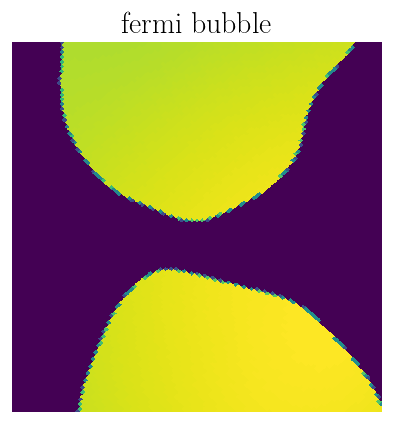

In [10]:
bub_data = np.load(data_dir + "/../fermi_data_128/template_bub.npy")
plot_gc(bub_data, cbar=False, title='fermi bubble')

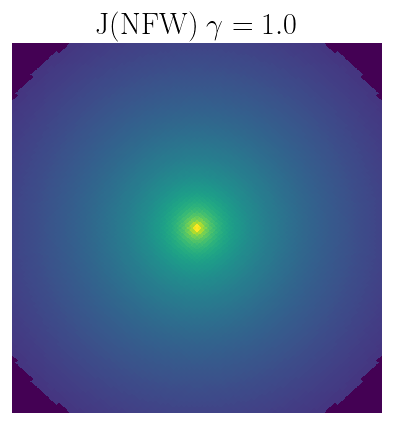

In [11]:
from templates.variable_templates import NFWTemplate
nfw_data = NFWTemplate().get_NFW2_template(gamma = 1.0)
plot_gc(np.clip(nfw_data, 1e-1, None), cbar=False, title=r'J(NFW) $\gamma=1.0$', norm='log')

### 1.3 build templates, normalize

We are not careful about exposure and psf here

In [12]:
from templates.rigid_templates import Template, EbinTemplate

In [13]:
temp_iso = EbinTemplate(exposure, norm_mask=mask_plane)
temp_bub = Template(bub_data, norm_mask=mask_plane)
temp_pib = EbinTemplate(modelopib, norm_mask=mask_plane)
temp_ics = EbinTemplate(modeloics, norm_mask=mask_plane)
temp_nfw = EbinTemplate(nfw_data[None,:]*exposure, norm_mask=mask_plane)

In [14]:
from scipy import optimize
from scipy import stats

def log_likelihood(logy, temps, counts):
    expn = np.dot(np.exp(logy), temps)
    return - np.sum(stats.poisson.logpmf(counts, expn))

def mle(temps, counts):
    #guess = np.random.uniform(-3, -1, size=(len(temps),))
    bounds = [(-2.1*np.log(10), 1.*np.log(10))]*len(temps)
    result = optimize.shgo(log_likelihood, bounds, args=(temps, counts), iters=5, sampling_method='sobol')
    if result.success:
        return result.x  # Normalizations
    else:
        raise RuntimeError("Optimization failed: " + result.message)

In [17]:
temps = [temp_bub, temp_pib, temp_ics, temp_nfw]
temp_names = ['bub', 'pib', 'ics', 'nfw']
result_norms = []

for i in range(10, 20):
    temps_at_bin = np.array([t.at_bin(i, mask=mask_roi) for t in temps])
    counts_at_bin = counts[i][~mask_roi]
    x = mle(temps_at_bin, counts_at_bin)
    print(x)
    result_norms.append(x)

result_norms = np.exp(np.array(result_norms))

[-1.56112705  1.29562888  0.62706376 -0.42172198]
[-1.81359579  0.97832973  0.24826288 -0.48800885]
[-2.1431108   0.59856161 -0.09630929 -0.73605051]
[-2.00579721  0.16526647 -0.29202479 -1.35629408]
[-2.1665977  -0.37779834 -0.58146079 -1.49650907]
[-2.01662067 -0.58557056 -1.15084496 -2.19700586]
[-2.62179438 -0.84230189 -1.52865091 -3.10125537]
[-2.53858288 -1.64978061 -1.54572639 -3.32793062]
[-2.8003492  -1.71652188 -2.62466826 -2.91147501]
[-2.99261189 -2.30672272 -2.22606491 -4.78814735]


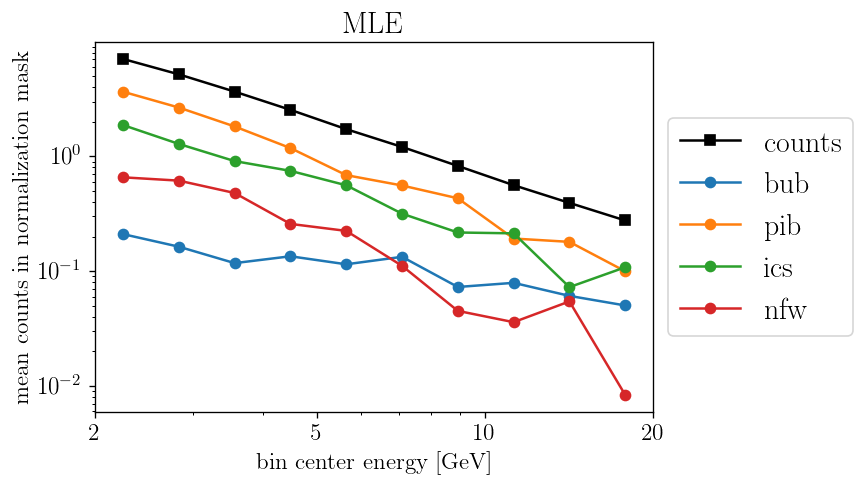

In [18]:
fig, axs = plt.subplots()

engs = ebin_engs[10:20]

ax = axs
ax.plot(engs, np.mean(counts[10:20, ~mask_plane], axis=1), '-s', label='counts', color='k')
for i in range(len(temps)):
    ax.plot(engs, result_norms[:, i], '-o', label=temp_names[i])

ax.set(xscale='log', yscale='log')
ax.set(title='MLE', xlabel='bin center energy [GeV]', ylabel='mean counts in normalization mask')
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set(xticks=[2, 5, 10, 20], xticklabels=[2, 5, 10, 20])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), bbox_transform=ax.transAxes)

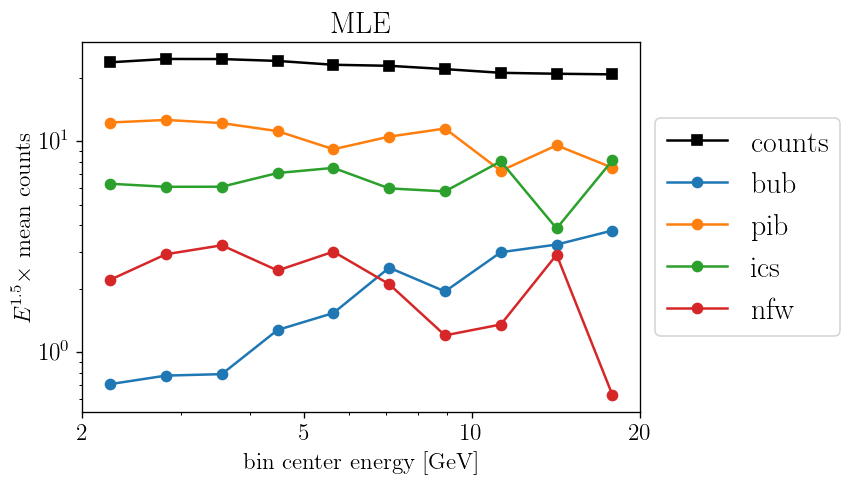

In [19]:
fig, axs = plt.subplots()

engs = ebin_engs[10:20]

ax = axs
ax.plot(engs, engs**1.5*np.mean(counts[10:20, ~mask_plane], axis=1), '-s', label='counts', color='k')
for i in range(len(temps)):
    ax.plot(engs, engs**1.5*result_norms[:, i], '-o', label=temp_names[i])

ax.set(xscale='log', yscale='log')
ax.set(title='MLE', xlabel='bin center energy [GeV]', ylabel=r'$E^{1.5}\times$ mean counts')
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set(xticks=[2, 5, 10, 20], xticklabels=[2, 5, 10, 20])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), bbox_transform=ax.transAxes)

In [20]:
for i in [0, 1, 2]:
    print(temp_names[i])
    print('bin 10 norm:', result_norms[0, i])
    print('power law slope:', stats.linregress(np.log10(engs), np.log10(result_norms[:,i]))[0])

bub
bin 10 norm: 0.20989937179213541
power law slope: -0.617646040089541
pib
bin 10 norm: 3.6532927310662675
power law slope: -1.7307902202902392
ics
bin 10 norm: 1.8721055449165802
power law slope: -1.5085817363892682


## 2. Simulate

In [21]:
truth_dict = dict(
    S_bub = 0.2, alpha_bub = -0.62,
    S_pib = 3.6, alpha_pib = -1.73,
    S_ics = 1.9, alpha_ics = -1.51,
)
td = truth_dict

In [22]:
nfw_p = np.polyfit(np.log10(engs), np.log10(result_norms[:,3]), 2)
nfw_fit = np.polyval(nfw_p, np.log10(engs))

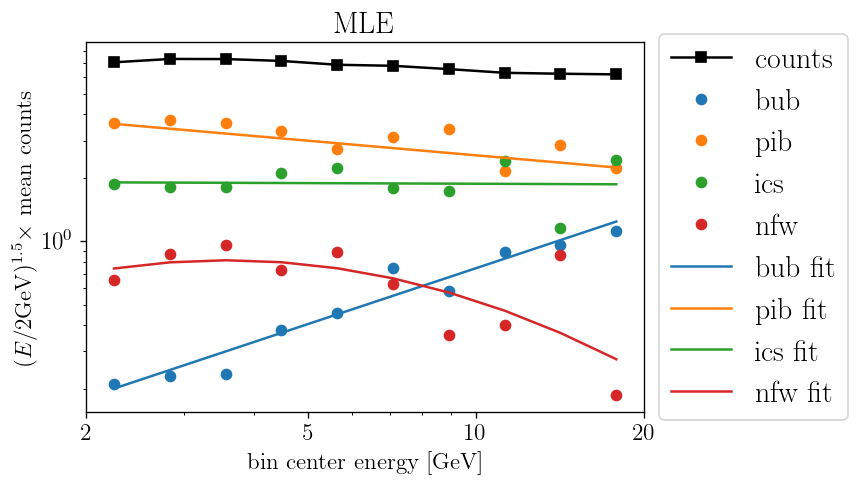

In [24]:
fig, axs = plt.subplots()

engs = ebin_engs[10:20]

ax = axs
ax.plot(engs, (engs/engs[0])**1.5*np.mean(counts[10:20, ~mask_plane], axis=1), '-s', label='counts', color='k')
for i in range(len(temps)):
    ax.plot(engs, (engs/engs[0])**1.5*result_norms[:, i], 'o', label=temp_names[i], color='C'+str(i))

ax.plot(engs, td['S_bub'] * (engs/engs[0])**(1.5+td['alpha_bub']), '-', label=temp_names[0] + ' fit', color='C0')
ax.plot(engs, td['S_pib'] * (engs/engs[0])**(1.5+td['alpha_pib']), '-', label=temp_names[1] + ' fit', color='C1')
ax.plot(engs, td['S_ics'] * (engs/engs[0])**(1.5+td['alpha_ics']), '-', label=temp_names[2] + ' fit', color='C2')
ax.plot(engs, (engs/engs[0])**(1.5)*10**nfw_fit, '-', label=temp_names[3] + ' fit', color='C3')

ax.set(xscale='log', yscale='log')
ax.set(title='MLE', xlabel='bin center energy [GeV]', ylabel=r'$(E/2\mathrm{GeV})^{1.5}\times$ mean counts')
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set(xticks=[2, 5, 10, 20], xticklabels=[2, 5, 10, 20])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), bbox_transform=ax.transAxes)

In [32]:
counts_sim = [np.zeros_like(mask_roi)]*10
for i in range(10, 20):
    expn  = temp_bub.at_bin(i) * td['S_bub'] * (engs[i-10]/engs[0])**td['alpha_bub']
    expn += temp_pib.at_bin(i) * td['S_pib'] * (engs[i-10]/engs[0])**td['alpha_pib']
    expn += temp_ics.at_bin(i) * td['S_ics'] * (engs[i-10]/engs[0])**td['alpha_ics']
    expn += temp_nfw.at_bin(i) * 10 ** nfw_fit[i-10]
    counts_at_bin = np.random.poisson(expn)
    counts_sim.append(counts_at_bin)
counts_sim = np.array(counts_sim)

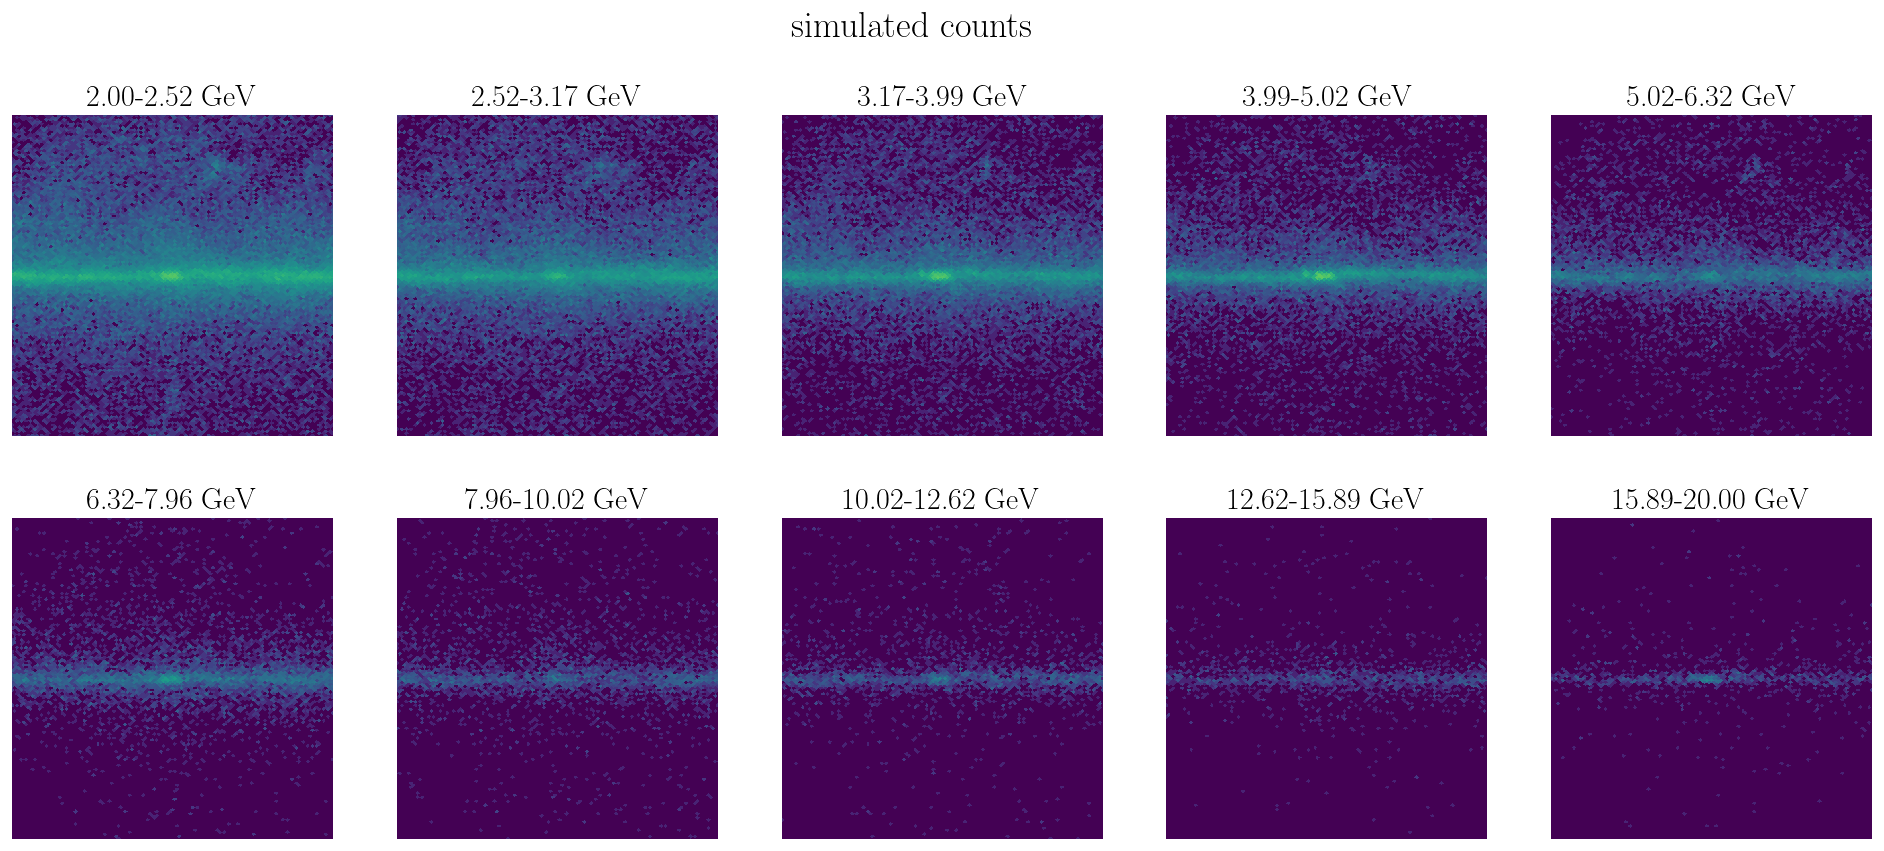

In [33]:
plot_ebins(np.clip(counts_sim, 0.5, None), suptitle='simulated counts', norm='log', max=1000, min=1, cbar=False)

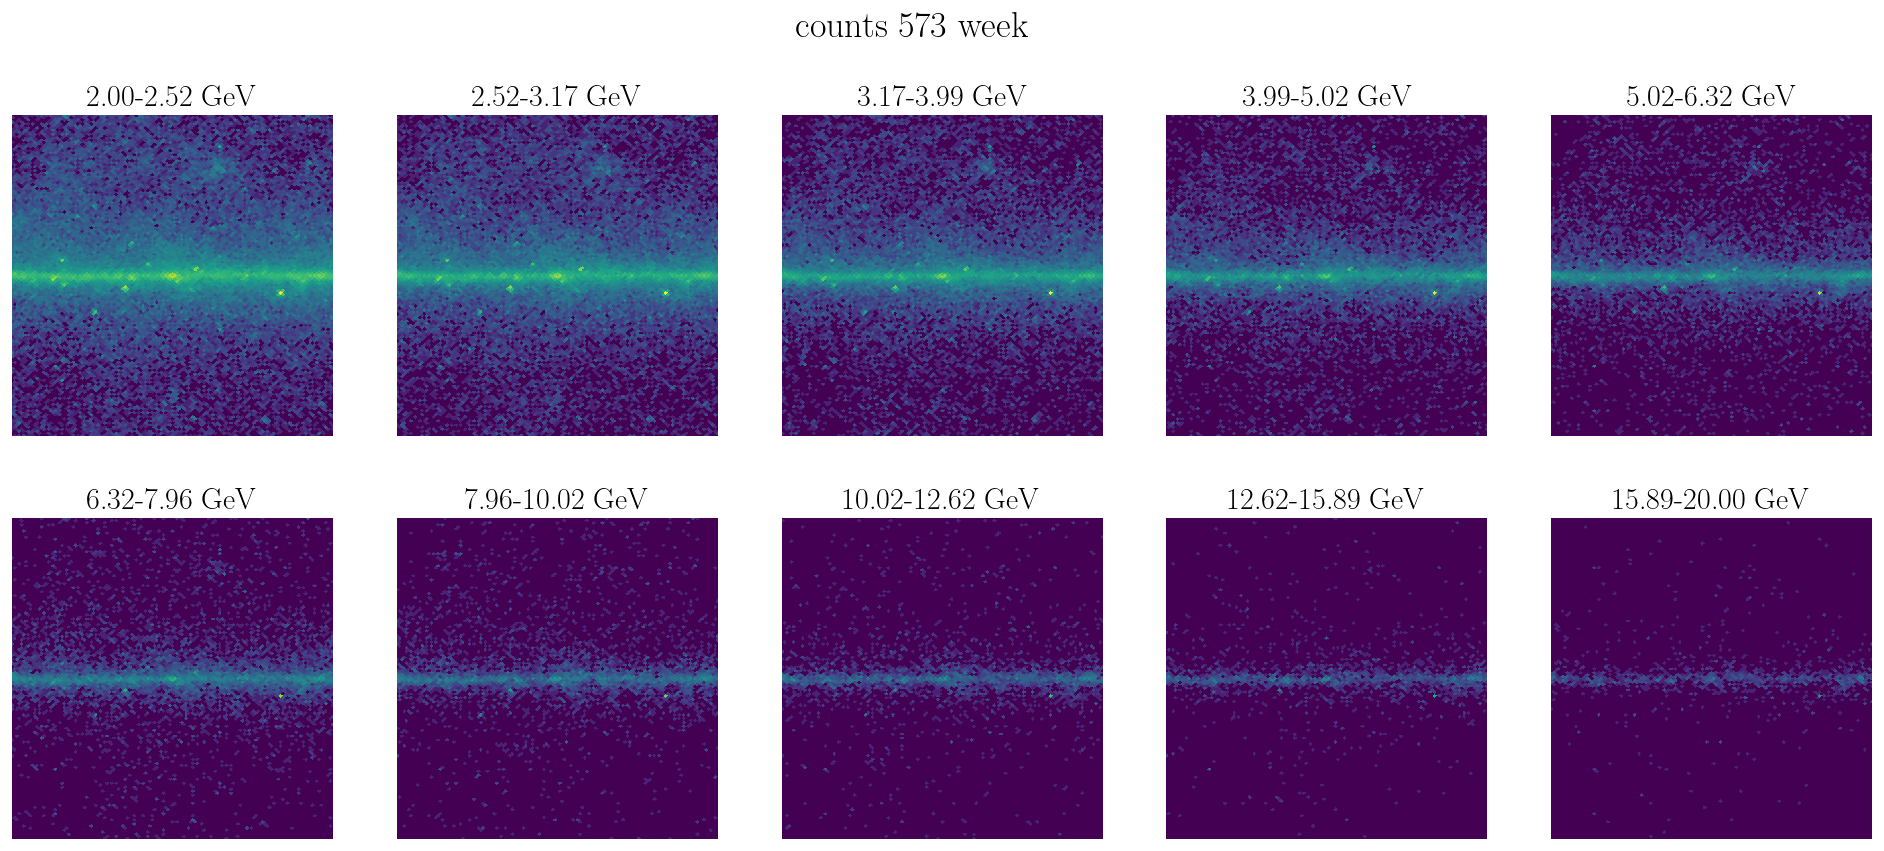

In [ ]:
counts = np.load(data_dir + "/counts-fwhm000-0512-bestpsf-nopsc.npy")
plot_ebins(np.clip(counts, 0.5, None), suptitle='counts 573 week', norm='log', max=1000, min=1, cbar=False)